In [3]:
import h5py
from astropy.stats import RipleysKEstimator
import numpy as np
import seaborn as sns
import math
import random
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skgstat import Variogram
import matplotlib.cm as cm
import matplotlib

In [4]:
f = h5py.File("../Mflare_data/M_flare_1h.hdf5","r+")
v = f['HARP377']
frame = v['flare_2011.02.13_17:38:00']
br = np.array(frame['Br'])
PIL = np.array(frame['PIL_MASK'])

In [5]:
br[br>5000] = 5000
br[br<-5000] = -5000
rho = 500/(377*744)
Npts = math.ceil(rho*br.shape[0]*br.shape[1])

In [6]:
def ptsgen(channel, threshold=200, rho=1):
    # channel must be a 2-D numpy array
    Npts = math.ceil(rho * channel.shape[0] * channel.shape[1])  # number of points to sample
    cond = np.abs(channel) >= threshold
    cand = np.nonzero(cond)  # above-threshold points
    N = cand[0].shape[0]
    if N == 0:
        return -1
    w = np.abs(channel[cond])  # sample weight
    idx = random.choices(range(N), weights=w, k=min(Npts, N))
    x_coor, y_coor = [], []
    for index in idx:
        x_coor.append(cand[0][index])
        y_coor.append(cand[1][index])

    coordinate = np.array([x_coor, y_coor]).transpose()
    return coordinate

5728
2174
239


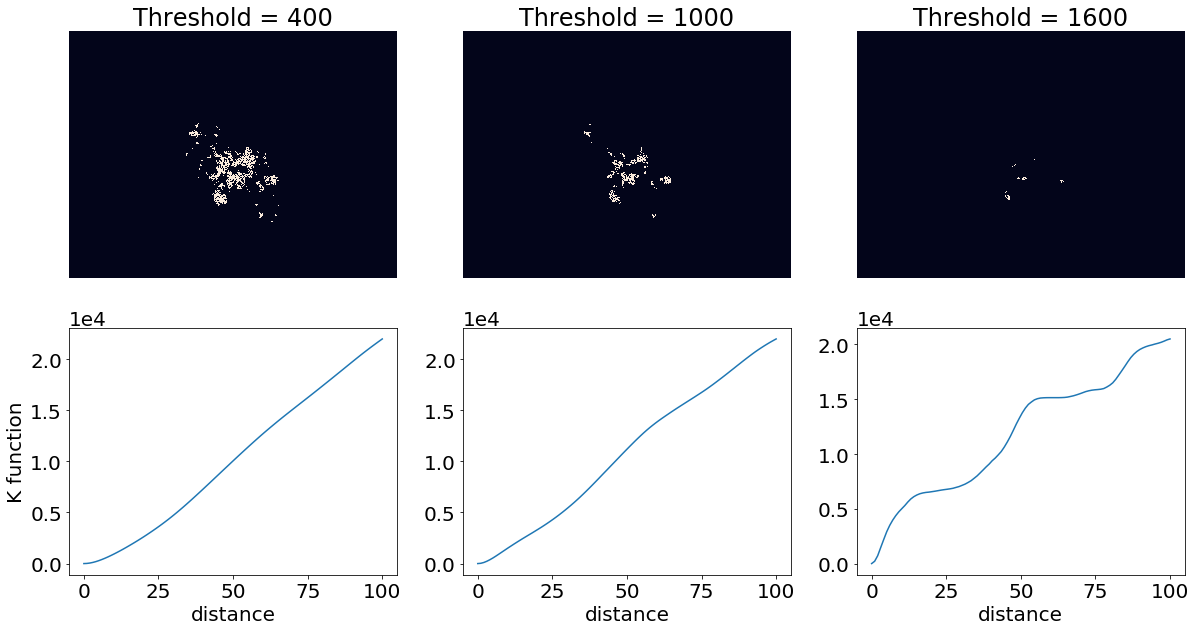

In [8]:
matplotlib.rcParams.update({'font.size': 20})
random.seed(20210320)
thres = [400, 1000, 1600]
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(20,10))

for t in thres:
    coordinate = ptsgen(br,threshold=t)
    final_coordinate = []
    for point in coordinate:
        x = point[0]
        y = point[1]
        if (PIL[x,y]!=0):
            final_coordinate.append([x,y])
    final_coordinate = np.array(final_coordinate)
    select_pixel = np.zeros_like(br)
    for pt in final_coordinate:
        x = pt[0]
        y = pt[1]
        select_pixel[x,y] = 1
    idx = thres.index(t)
    print(final_coordinate.shape[0])
    plt.subplot(2,3,idx+1)
    plt.title("Threshold = " + str(t))
    sns.heatmap(select_pixel, cbar=False,xticklabels=False,yticklabels=False)
    
    final_coordinate = final_coordinate + np.random.normal(loc=0, scale=1, size=final_coordinate.shape)
    area = np.int(np.sum(PIL != 0))
    pils = np.nonzero(PIL)
    Kest = RipleysKEstimator(area=area, x_max=np.int(max(pils[0])), x_min=np.int(min(pils[0])),
                                             y_max=np.int(max(pils[1])), y_min=np.int(min(pils[1])))
    r = np.linspace(0, 100, 100)
    res = Kest(data=final_coordinate, radii=r, mode='ripley')  # Ripley's K feature
    plt.subplot(2,3,idx+4)
    plt.plot(r,res)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.xlabel("distance")
    if idx==0:
        plt.ylabel("K function")

In [8]:
fig.savefig("../paper_writing/ripley_K_377.png", dpi=300)

## Variogram

In [9]:
thres = [400, 1000, 1600]
allV = []

for t in thres:
    coordinate = ptsgen(br,threshold=t)
    final_coordinate = []
    z = []
    for point in coordinate:
        x = point[0]
        y = point[1]
        if (PIL[x,y]!=0):
            final_coordinate.append([x,y])
            z.append(br[x,y])
    final_coordinate = np.array(final_coordinate)
    z = np.array(z)
    V = Variogram(coordinates=final_coordinate, values=z, model="exponential")
    allV.append(V)

/Users/husun/anaconda3/lib/python3.7/site-packages/skgstat/Variogram.py:1631: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


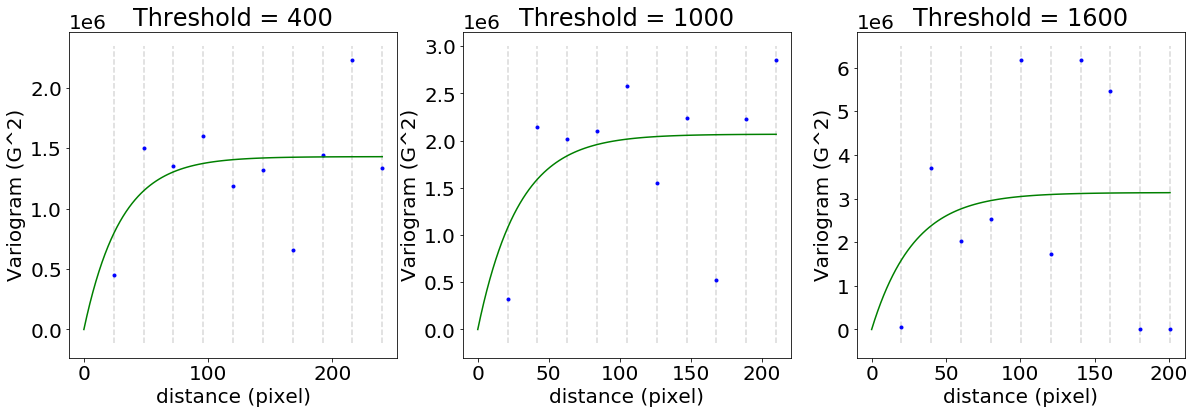

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))
for idx in range(3):
    # ax[idx] = plt.subplot(1,3,idx+1)
    pV = allV[idx]
    pV.plot(axes=ax[idx],hist=False)
    ax[idx].set_ylabel("Variogram (G^2)")
    ax[idx].ticklabel_format(axis="y",style="sci",scilimits=(4,6))
    ax[idx].set_title("Threshold = " + str(thres[idx]))
    ax[idx].set_xlabel("distance (pixel)")

In [13]:
fig.savefig("../paper_writing/variogram_377.png",dpi=300)

In [14]:
f.close()